In [5]:
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from itertools import accumulate
import torch.nn.functional as F
import time
import operator
import math
from dask import array as da
import cupy
%matplotlib inline

# https://medium.com/deep-learning-hk/compute-document-similarity-using-autoencoder-with-triplet-loss-eb7eb132eb38
# https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
# FaceNet: https://arxiv.org/pdf/1503.03832.pdf

In [6]:
import torch

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
def save_model(model, epochs, losses):
    timestr = time.strftime("%m%d-%H%M%S")
    prefix = "../models/"
    torch.save(model, prefix + "%s_%sE.pt" % (timestr, epochs))
    plt.plot(losses)
    plt.savefig(prefix + "%s_plot.jpg" % (timestr,), bbox_inches='tight', dpi=150)

In [9]:
def dfCheck(df):
    
    # Any column is > 20% null values
    if any(cnt / len(df) > 0.2 for cnt in df.isna().sum()):
        return False
    
    return True

In [10]:
tables = defaultdict(list)
path = "../Data/tables_025.csv"
maxRowLen = 0
maxRowLenR = ""
maxRowLenT = ""
allRows = []

with open(path, "r") as f:
    tableCount = 0
    for line in f:
        if line.startswith("List of"):
            tableCount += 1
            
tableFrac = 0.25
tablesLim = int(tableCount * tableFrac)
tablesRead = 0

print("Reading " + str(tablesLim) + " tables")

with open(path, "r") as f:
    reader = csv.reader(f)
    tableTitle = ""
    table = []
    
    for row in reader:
        if len(row) == 1 and row[0].startswith("List of"):
            if tableTitle: # Ignore first table, doesn't exist yet
                if dfCheck(pd.DataFrame(table)):
                    joinedRows = ['|||'.join(row) for row in table]
                    tables[tableTitle].append(joinedRows)
                    allRows.extend(joinedRows)
                table = []
            tableTitle = row[0]
            
            tablesRead += 1
            if tablesRead > tablesLim:
                break
            
        elif len(row) != 0:
            table.append(row)
            
            
print("Total tables analyzed: " + str(sum(len(val) for val in tables.values())))
maxRowLen = max(len(row) for row in allRows)
print("Maximum row length: " + str(maxRowLen))

Reading 41575 tables
Total tables analyzed: 39393
Maximum row length: 1017


In [11]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(allRows)
id_count = len(tokenizer.word_index)

In [12]:
"""
Convert each string into a list of its characters, converted to ints
Filter out rows which are too long (i.e. not many other rows at that length)
"""
import json

table_chars = []
sizes = [len(seq) for seq in allRows]
mu, sigma = np.mean(sizes), np.std(sizes)
maxRowLen = int(mu)

for i, category in enumerate(tables):
    for i, table in enumerate(tables[category]):
        tokens = tokenizer.texts_to_sequences(table)
        char_table = np.array([np.pad(seq, (0, maxRowLen - len(seq))) for seq in tokens if len(seq) <= maxRowLen])

        if len(char_table) >= 10:  # Remove tables that no longer have sufficient rows. We use 10 to allow for training & testing purposes   
            table_chars.append(char_table)

table_tensors = [torch.tensor(table) for table in table_chars]
print("Total # of tables in dataset: " + str(len(table_tensors)))

Total # of tables in dataset: 15762


In [13]:
# with open("../Data/tables.json", "w") as f:
#     f.write(json.dumps([l.tolist() for l in table_chars]))

In [14]:
"""
Model based on https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
"""

class TransformerModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, d_hid, nlayers, dropout = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = src.T
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class LinearModel(nn.Module):
    def __init__(self, emb_dim, h_activ=nn.LeakyReLU()):
        super().__init__()
        # Defining the fully connected layers
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            # nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            # nn.MaxPool1d(3, stride=2),
            
            # nn.Conv1d(24, 96, kernel_size=5,stride=1,padding=2),
            # nn.ReLU(inplace=True),
            # nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            # nn.MaxPool1d(3, stride=2),
            # nn.Dropout(p=0.3),

            # nn.Conv1d(96,128 , kernel_size=3,stride=1,padding=1),
            # nn.ReLU(inplace=True),
            # nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            # nn.MaxPool1d(3, stride=2),
            # nn.Dropout(p=0.3),

            # nn.Conv1d(128, 196, kernel_size=1,stride=1,padding=0),
            # nn.ReLU(inplace=True),
        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(1440, 1024),
            nn.Dropout(p=0.5),
            h_activ,
            nn.Linear(1024, 512),
            nn.Dropout(p=0.5),
            h_activ,
            nn.Linear(512, 256),
            # h_activ(inplace=True),
            # nn.Linear(256, 128),
            # h_activ(inplace=True),
            # nn.Linear(128, 128),
            # h_activ(inplace=True),
            # nn.Linear(128, 128),
            # h_activ(inplace=True),
            # nn.Linear(128, 128),
            # h_activ(inplace=True),
            # nn.Linear(128, 128),
            # h_activ(inplace=True),
            # nn.Linear(128, 256),
            # h_activ(inplace=True)
        )
        
    def forward(self, x):
        # Forward pass 
        x = x.unsqueeze(1)  # Only one channel
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

In [15]:
class TableDataset(torch.utils.data.Dataset):
    def __init__(self, tables):
        self.sizes = torch.tensor([table.shape[0] for table in tables])
        self.table_positions = self.get_table_positions()
        self.rows = torch.cat(tables, 0)
        self.max = torch.max(self.rows)
        self.rows = self.rows / self.max  # Normalization

    def __len__(self):
        return len(self.sizes)

    def __getitem__(self, idx):
        if idx == 0:
            return self.rows[:self.sizes[0]]
            
        return self.rows[self.sizes[idx-1]:self.sizes[idx]]

    def get_table_positions(self):
        return np.array([0] + list(accumulate(self.sizes, operator.add)), dtype=np.int32)

    def shuffle(self):
        idxs = np.random.permutation(len(self.sizes))
        tables = torch.split(self.rows, list(self.sizes))  # split_size_or_sections needs a list for some reason
        tables = [tables[idx] for idx in idxs]
        self.rows = torch.cat(tables, 0)
        self.sizes = self.sizes[idxs]
        self.table_positions = self.get_table_positions()
        return

    def get_triplets(self, model, start_idx, batch_size, rows_per_table=40):
        """
        Using an online novel triplet mining strategy described in https://arxiv.org/pdf/1503.03832.pdf
        
        We perform all computations in numpy since it is much faster than with pytorch
        """
        # t = time.time()
        table_positions = self.table_positions[start_idx: start_idx+batch_size+1]

        # Get 5 rows per table for a subset of the tables
        size = (rows_per_table, min(batch_size+1, table_positions.shape[0]) - 1)
        chosen_row_idxs = np.random.randint(table_positions[:-1], table_positions[1:], size=size).T.flatten()
        chosen_rows = self.rows[chosen_row_idxs].float()

        # turn off autograd to speed up computation
        with torch.no_grad():
            embeddings = np.array(model(chosen_rows.to(device)).cpu())
            embeddings = da.array(embeddings)
            embeddings = embeddings.map_blocks(cupy.asarray)

        dists = da.matmul(embeddings, embeddings.T)

        pos_mask = da.zeros(dists.shape, dtype=bool).map_blocks(cupy.asarray)
        for i in range(0, embeddings.shape[0], rows_per_table):
            pos_mask[i:i+rows_per_table,i:i+rows_per_table] = 1

        # Ensure the same rows are not comapred against each other
        # pos_mask = da.fill_diagonal(pos_mask,0)
        positive_dists = da.where(pos_mask, dists, 0).map_blocks(cupy.asarray)
        negative_dists = da.where(pos_mask, 0, dists).map_blocks(cupy.asarray)

        anchor_idxs = np.arange(chosen_rows.shape[0])
        positive_idxs = da.argmax(positive_dists, axis=1).compute()
        negative_idxs = da.argmin(negative_dists, axis=1).compute()
        
        # print("Elapsed: " + str(time.time() - t), len(chosen_rows), len(anchor_idxs))
        return (
            chosen_rows.to(device), 
            torch.tensor(anchor_idxs).long().to(device), 
            torch.tensor(positive_idxs).long().to(device), 
            torch.tensor(negative_idxs).long().to(device)
        )

table_tensors_train = []
table_tensors_val = []
table_tensors_test = []
take_tables = 500
torch.manual_seed(42)

# Generate training, validation, and testing datasets
for table in table_tensors[:take_tables]:
    # Select 5 random rows to be validation / test rows
    non_train_idxs = torch.randint(0, table.shape[0], size=(1, 5)).flatten()
    val_idxs, test_idxs = non_train_idxs[:3], non_train_idxs[3:]

    # All other rows are training rows
    train_idxs = torch.ones(table.shape[0], dtype=bool)
    train_idxs[non_train_idxs] = False

    # append the data to appropriate list
    table_tensors_train.append(table[train_idxs])
    table_tensors_val.append(table[val_idxs])
    table_tensors_test.append(table[test_idxs])

dataset_train = TableDataset(table_tensors_train)
dataset_val = TableDataset(table_tensors_val)
dataset_test = TableDataset(table_tensors_test)

In [22]:
def train(model, optimizer, loss_fn, data, epoch, BATCH_SIZE=125):
    model.train()
    losses = []

    for i in tqdm(range(0, len(data), BATCH_SIZE), desc="EPOCH %s" % (epoch,)):
        batch, anchors, positives, negatives = data.get_triplets(model, i, BATCH_SIZE)
        optimizer.zero_grad()
        anchor_embs = model(batch[anchors])
        positive_embs = model(batch[positives])
        negative_embs = model(batch[negatives])
            
        loss = loss_fn(anchor_embs, positive_embs, negative_embs)
        
        loss.backward() # back-propagation, could do manually
        optimizer.step() # Adjusts the weights for us
        losses.append(loss.item())

    return losses

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        precision_scores = data.get_average_precision(model)

    return precision_scores


EPOCHS = 250
model = LinearModel(256).to(device)
loss_fn = nn.TripletMarginLoss(1, 2).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.0005)
train_losses = []
SAVE_MODEL = False

for epoch in range(EPOCHS):
    dataset_train.shuffle()
    train_losses += train(model, optimizer, loss_fn, dataset_train, epoch)

if SAVE_MODEL:
    save_model(model, EPOCHS, train_losses)
else:
    plt.plot(train_losses)


EPOCH 95:   0%|          | 0/4 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [17]:
with torch.no_grad():
    batch, anchors, positives, negatives = dataset_train.get_triplets(model, 0, 2)
    positive_embs = model(batch[positives]) 
    negative_embs = model(batch[negatives]) 
    anchor_embs = model(batch[anchors])

    print(anchor_embs)
    print(positive_embs)
    print(negative_embs)

    print(loss_fn(anchor_embs, positive_embs, negative_embs))

tensor([[ 0.0010,  0.0134, -0.2106,  ..., -0.0554,  0.0902,  0.0899],
        [ 0.0375, -0.0513, -0.2902,  ..., -0.0791,  0.0995,  0.0953],
        [-0.0314,  0.0307, -0.3583,  ..., -0.0922,  0.1017,  0.1224],
        ...,
        [ 0.0902, -0.0440, -0.3408,  ..., -0.1018,  0.1449,  0.0746],
        [ 0.0026, -0.0092, -0.3126,  ..., -0.1067,  0.1347,  0.0763],
        [ 0.1125,  0.0361, -0.4298,  ..., -0.0044,  0.1290,  0.0997]],
       device='cuda:0')
tensor([[ 0.0242,  0.0525, -0.2317,  ..., -0.0560,  0.1813,  0.0881],
        [ 0.0364, -0.0108, -0.3709,  ..., -0.0169,  0.1275,  0.1083],
        [ 0.0767,  0.0160, -0.3409,  ..., -0.0577,  0.0896,  0.1304],
        ...,
        [ 0.0709, -0.0495, -0.2397,  ..., -0.0932,  0.1386,  0.0855],
        [ 0.0195, -0.0245, -0.4052,  ...,  0.0355,  0.1731,  0.0315],
        [-0.0329, -0.0304, -0.3996,  ..., -0.1162,  0.0850,  0.0565]],
       device='cuda:0')
tensor([[-0.0762,  0.0265, -0.2335,  ..., -0.0523,  0.1204,  0.0669],
        [ 0.10

In [18]:
batch, anchors, positives, negatives = dataset_val.get_triplets(model, 0, 2)

In [19]:
for x, y in model.named_parameters():
    print(x, y)

cnn1.0.weight Parameter containing:
tensor([[[ 0.1876, -0.1956,  0.1199, -0.0543,  0.1775, -0.0072,  0.1354,
           0.2613, -0.0978, -0.2690,  0.2563]],

        [[-0.1267,  0.1088,  0.2355,  0.0369,  0.3136,  0.2897,  0.0594,
           0.1950,  0.1433,  0.3930,  0.3086]],

        [[-0.1782,  0.0611,  0.2167,  0.2848,  0.1679,  0.1866, -0.0032,
           0.0499, -0.1610,  0.2626,  0.2600]],

        [[-0.1502, -0.2336,  0.2127, -0.2418,  0.1749, -0.2657, -0.1395,
          -0.1155,  0.2563, -0.0462,  0.2353]],

        [[ 0.1827,  0.4117,  0.3580,  0.3754,  0.4056,  0.0466,  0.0322,
           0.1730,  0.3032, -0.0561, -0.1941]],

        [[-0.2134, -0.1260,  0.0435, -0.0316, -0.0728, -0.1275,  0.0710,
          -0.2247,  0.2684, -0.0423,  0.0509]],

        [[ 0.1062, -0.0863,  0.2363, -0.0014,  0.0102, -0.2723,  0.0321,
           0.1137,  0.0602,  0.0049,  0.2395]],

        [[ 0.2515,  0.2067, -0.0574,  0.0078, -0.2530, -0.2902, -0.1313,
          -0.0537, -0.2408, -0.3075, 

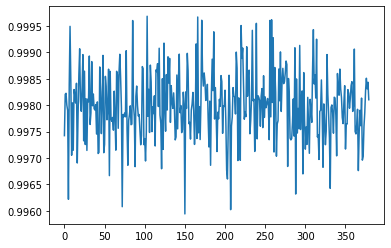

In [23]:
plt.plot(train_losses)

In [21]:
x = da.array([[1, 2], [3, 4]])
x

ImportError: Dask diagnostics requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[diagnostics]" --upgrade  # or python -m pip install

dask.array<array, shape=(2, 2), dtype=int32, chunksize=(2, 2), chunktype=numpy.ndarray>

In [ ]:
arr = []
for i, table in enumerate(table_chars):
    for row in table:
        arr.append([i] + list(row))

arr = np.array(arr)
df = pd.DataFrame(arr)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0,6,3,5,33,1,1,1,21,11,...,0,0,0,0,0,0,0,0,0,0
1,0,12,1,1,1,17,3,5,33,2,...,0,0,0,0,0,0,0,0,0,0
2,0,19,1,1,1,10,9,3,5,2,...,0,0,0,0,0,0,0,0,0,0
3,0,25,1,1,1,35,7,11,11,7,...,0,0,0,0,0,0,0,0,0,0
4,0,28,1,1,1,3,11,24,4,6,...,0,0,0,0,0,0,0,0,0,0
